In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%cd /content/drive/MyDrive/PHI/ToF_ML/src

/content/drive/MyDrive/PHI/ToF_ML/src


In [3]:
from ast import literal_eval
df = pd.read_csv('../data/full_corrected_data.csv')
df['channels']  = df['channels'].apply(literal_eval)
df['intensities'] = df['intensities'].apply(literal_eval)
df['masses'] = df['masses'].apply(literal_eval)

In [4]:
df.dropna(inplace=True)
df = df[df['intensities'].apply(len)> 0].copy()
df.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,adjusted_original_proportion_identified,avg_dist_frags_low,avg_dist_frags_high,adjusted_proportion_identified,proportion_identified,diff,prop_diff_in_low,calibration
0,0106301.cas,0.387384,-0.275004,0.0,1.248,"[2644.0367300000003, 3505.0183700000002, 4162....","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...","[1.0065519723918102, 2.015029094672708, 3.0191...",0.398438,0.001298,0.002255,0.515625,0.515625,0.000958,0.738174,0
1,0107316.cas,0.387113,-0.278302,0.0,1.248,"[2647.00072, 3508.9949100000003, 4164.59326000...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...","[1.00101811517532, 2.0077555328930656, 3.00565...",0.129771,0.001537,0.002586,0.511450,0.511450,0.001049,0.682225,0
2,0110203.cas,0.379037,-0.271056,0.0,4.992,"[1973.87665, 2049.0706800000003, 2122.01224, 2...","[23352, 74717, 10387, 947, 12344, 9121, 249, 4...","[11.998071176139083, 13.003971096434277, 14.01...",0.388889,0.001640,0.001858,0.444444,0.444444,0.000218,0.133100,0
3,0110212.cas,0.379177,-0.269744,0.0,4.992,"[672.00298, 891.90543, 1970.94521, 2046.11295,...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...","[1.0045194511091773, 2.012140966655108, 11.978...",0.379630,0.001337,0.002206,0.592593,0.592593,0.000868,0.649178,0
4,0116511.cas,0.383360,-0.302184,0.0,1.248,"[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...","[1.0049940659400325, 2.0094784706009245, 3.022...",0.350427,0.001397,0.002171,0.487179,0.467213,0.000774,0.554114,0


In [5]:
from data_transformation import mass_formula,  get_amu_channel
def get_severity(original_slope, original_offset, new_slope, new_offset,
                 bin_size, start_time, channel=200, scaler=.02):
    '''
    Asses severity of error on a spectra. Returns linear value with numbers below
    around .2 being well calibrated and those above .2 being poorly calibrated.
    '''
    two_hundred_channel = get_amu_channel(bin_size, start_time, original_slope,
                                          original_offset, channel)
    orig_200 = mass_formula(np.array(two_hundred_channel), bin_size, start_time,
                            original_slope, original_offset)
    new_200 = mass_formula(np.array(two_hundred_channel), bin_size, start_time,
                           new_slope, new_offset)
    dif = abs(orig_200 - new_200)
    return (dif / scaler)

In [6]:
from data_transformation import get_amu_slope, get_amu_offset
def augment_spectrum(slope, offset, bin_size, start_time, modifier=1):
    '''
    Add a random amount of error to a spectrum so that it falls onto a
    normal distribution of spectra with error.
    '''
    two_hundred_channel = get_amu_channel(bin_size, start_time, slope, offset,
                                          200)
    
    vals = [slope, offset]
    #new_vals = [0, 0]
    for num in range(2):
        sign, amount = tuple(np.random.rand(2))
        amount = amount / modifier
        orig = mass_formula(np.array(two_hundred_channel), bin_size, start_time,
                            vals[0], vals[1])
        mult = -1 if sign < .5 else 1
        if num == 0 :
            new_offset = get_amu_offset(bin_size, start_time, vals[0],
                                        two_hundred_channel,
                                        orig + mult * amount)
            vals[1] = new_offset
        else:
            new_slope = get_amu_slope(bin_size, start_time, vals[1],
                                      two_hundred_channel, orig + mult * amount)
            vals[0] = new_slope
    return tuple(vals)

In [7]:
from data_transformation import generate_calibrated_data
def augment_data(data, severity_scaler=0.02, spectrum_modifier=95):
    '''
    Returns new dataframe with augmented slope and offset values with error.
    Also adds a severity column showing how much error each spectrum has.
    '''
    df = data.copy()
    new_slopes = []
    new_offsets = []
    severities = []
    for row in df.itertuples():
        slope = row.MassOverTime
        offset = row.MassOffset
        bin_size = row.SpecBinSize
        start_time = row.StartFlightTime
        new_slope, new_offset = augment_spectrum(slope, offset, bin_size,
                                                 start_time, spectrum_modifier)
        new_slopes.append(new_slope)
        new_offsets.append(new_offset)
        severities.append(get_severity(slope, offset, new_slope, new_offset,
                                       bin_size, start_time,
                                       scaler=severity_scaler))
    df['MassOverTime'] = new_slopes
    df['MassOffset'] = new_offsets
    df['Severity'] = severities
    return generate_calibrated_data(df)

In [8]:
test = df.loc[56]
bin_size = test.SpecBinSize
start_time = test.StartFlightTime
slope = test.MassOverTime
offset = test.MassOffset
hundred_channel = get_amu_channel(bin_size, start_time, slope, offset)
two_hundred_channel = get_amu_channel(bin_size, start_time, slope, offset,
                                        200)

In [9]:
masses_100 = []
masses_200 = []
sevs = []
for num in range(500):
    a, b = augment_spectrum(slope, offset, bin_size, start_time, 90)
    mass_100 = mass_formula(np.array(hundred_channel), bin_size, start_time,
                            a, b)
    masses_100.append(mass_100)
    mass_200 = mass_formula(np.array(two_hundred_channel), bin_size, start_time,
                            a, b)
    masses_200.append(mass_200)
    sevs.append(get_severity(slope, offset, a, b, bin_size, start_time))
masses_100 = np.array(masses_100) - 100
masses_200 = np.array(masses_200) - 200

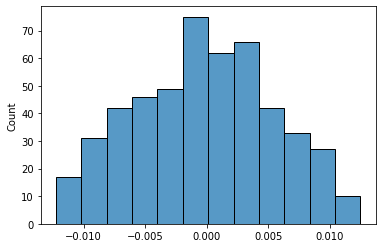

In [10]:
sns.histplot(masses_100)

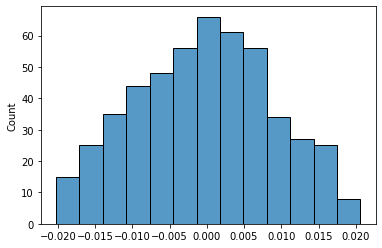

In [11]:
sns.histplot(masses_200)

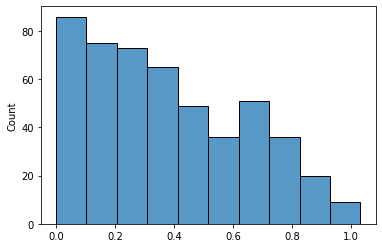

In [12]:
sns.histplot(sevs)

In [13]:
test_df = df.drop(['adjusted_original_proportion_identified', 'avg_dist_frags_low',
       'avg_dist_frags_high', 'adjusted_proportion_identified',
       'proportion_identified', 'diff', 'prop_diff_in_low', 'calibration'], axis=1)

In [14]:
test = augment_data(test_df)

In [15]:
test.head()

,file_name,MassOverTime,MassOffset,StartFlightTime,SpecBinSize,channels,intensities,masses,Severity
0,0106301.cas,0.387384,-0.275343,0.0,1.248,"[2644.0367300000003, 3505.0183700000002, 4162....","[73874, 1234, 138, 610, 1216, 4159, 8958, 1084...","[1.0058665202825667, 2.0140566859795688, 3.017...",0.522835
1,0107316.cas,0.387105,-0.278522,0.0,1.248,"[2647.00072, 3508.9949100000003, 4164.59326000...","[49864, 1034, 168, 4696, 8247, 13992, 17903, 2...","[1.0005228272150697, 2.007028576748073, 3.0047...",0.751524
2,0110203.cas,0.379043,-0.271295,0.0,4.992,"[1973.87665, 2049.0706800000003, 2122.01224, 2...","[23352, 74717, 10387, 947, 12344, 9121, 249, 4...","[11.99683546895643, 13.002701123678051, 14.017...",0.009528
3,0110212.cas,0.379170,-0.270099,0.0,4.992,"[672.00298, 891.90543, 1970.94521, 2046.11295,...","[34398, 304, 2223, 3521, 5205, 6509, 99, 115, ...","[1.003763246010448, 2.011049863679481, 11.9753...",0.860730
4,0116511.cas,0.383360,-0.302319,0.0,1.248,"[2726.98153, 3594.53649, 4265.28736, 7866.5038...","[42995, 602, 151, 17912, 9536, 17609, 29604, 5...","[1.004727382654923, 2.0091031404947217, 3.0218...",0.160061


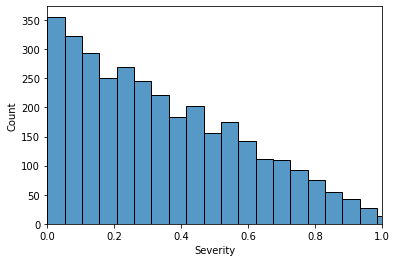

In [17]:
hist = sns.histplot(test['Severity'])
hist.set_xlim(0, 1)
plt.show()

In [ ]:
def get_base_fragment_stats(row, spots, slope_val, offset_val)
    slope = slope_val
    offset = offset_val
    peaks = []
    peaks = mass_formula(np.array(row.channels), row.SpecBinSize, row.StartFlightTime, slope,
                   offset)
    masses, frags1, dist1, masses2, frags2, dist2 = get_frags_dists(peaks,
                                                                    spots,
                                                                    [.003,.007])
    prop = len(masses) / (len(peaks[peaks<236]) + 1)
    low_dist = 0
    high_dist = 0
    if len(dist1) > 0:
        low_dist = np.mean(dist1)
    if len(dist2) > 0:
        high_dist = np.mean(dist2)
    return prop, low_dist, high_dist, len(masses), np.array(masses), np.array(frags1)

In [ ]:
def get_fragment_retention():

In [62]:
from data_transformation import get_frags_dists
def get_frag_features(data, frags, amu=150, amt_one=.0015, amt_two=.003):
    '''
    Calculate features for each example. Gets fragment databse stats for each
    unchanged example, then calculates the same stats for 2 small augmentations
    to slope and offset respectively.

    Returns a list of lists w/ shape (16, 3) where the 16 outer lists represent
    each stat, and the 3 inner lists contain the value of the stat for no,
    positive, and negative augmentations.
    '''
    cols = [[[] for num in range(3)] for num in range(16)]
    for row in data.itertuples():
        a, b, c, d = recalibrate(row, frags, 0, 0, num_peaks=True)
        cols[0][0].append(a)
        cols[1][0].append(b)
        cols[2][0].append(c)
        cols[3][0].append(d)
        for i, n in enumerate([1, -1]):
            chan = get_amu_channel(row.SpecBinSize,
                                   row.StartFlightTime,
                                   row.MassOverTime,
                                   row.MassOffset,
                                   amu
                                   )
            slopes = [row.MassOverTime, row.MassOverTime,
                      get_amu_slope(row.SpecBinSize, row.StartFlightTime,
                                    row.MassOffset, chan, amu + n * amt_one),
                      get_amu_slope(row.SpecBinSize, row.StartFlightTime,
                                    row.MassOffset, chan, amu + n * amt_two)
                     ]
            offsets = [get_amu_offset(row.SpecBinSize, row.StartFlightTime,
                                      row.MassOverTime,
                                      chan, amu + n * amt_one),
                       get_amu_offset(row.SpecBinSize, row.StartFlightTime,
                                      row.MassOverTime, chan,
                                      amu + n * amt_two),
                       row.MassOffset, row.MassOffset
                      ]

            for ind, j in enumerate([0, 4, 8, 12]):
                a, b, c, d = recalibrate(row, frags, slopes[ind],
                                            offsets[ind],
                                            augment=False,
                                            num_peaks=True)
                
                cols[j][i + 1].append(a)
                cols[j + 1][i + 1].append(b)
                cols[j + 2][i + 1].append(c)
                cols[j + 3][i + 1].append(d)
    return cols 

In [63]:
from data_transformation import get_frags, recalibrate
frags = get_frags()['FragmentMass']
cols = get_frag_features(test, frags)

In [64]:
from data_transformation import (get_isotope_data, get_ranges,
                                 get_suspicious_peaks, get_peak_suspiciousness)
isotopes = get_isotope_data()
ranges = get_ranges(isotopes['Isotope Masses'], 2000)
suspicious_peaks = test['masses'].apply(get_suspicious_peaks, args=(ranges, ))
num_sus_peaks = pd.Series(suspicious_peaks).apply(len)
prop_sus_peaks = num_sus_peaks / test['masses'].apply(len)
peak_susses =  test['masses'].apply(get_peak_suspiciousness, args=(ranges, ))
avg_peak_sussness = pd.Series(peak_susses).apply(np.mean)

In [65]:
from sklearn.model_selection import train_test_split
d = {'Miscalibrated': test['Severity'],
     'Proportion Assigned': cols[0][0],
     'Low Distance From Fragment': cols[1][0],
     'High Distance From Fragment': cols[2][0],
     'Peaks Matched' : cols[3][0],
     'Diff Proportion w/ Offset Added': -1 * (np.array(cols[0][0]) - np.array(cols[0][1])),
     'Low Distance w/ Offset Added':   (np.array(cols[1][0]) - np.array(cols[1][1])),
     'High Distance w/ Offset Added':  (np.array(cols[2][0]) - np.array(cols[2][1])),
     'Peaks Matched Offset Added' :  -1 *( np.array(cols[3][0]) - np.array(cols[3][1])),
     'Diff Proportion w/ More Offset Added': -1 * (np.array(cols[0][0]) - np.array(cols[4][1])),
     'Low Distance w/ More Offset Added':   (np.array(cols[1][0]) - np.array(cols[5][1])),
     'High Distance w/ More Offset Added':  (np.array(cols[2][0]) - np.array(cols[6][1])),
     'Peaks Matched More Offset Added' :  -1 *( np.array(cols[3][0]) - np.array(cols[7][1])),
     'Proportion w/ Offset Subbed':   -1 * (np.array(cols[0][0]) - np.array(cols[0][2])),
     'Low Distance w/ Offset Subbed':  (np.array(cols[1][0]) - np.array(cols[1][2])),
     'High Distance w/ Offset Subbed':  (np.array(cols[2][0]) - np.array(cols[2][2])),
     'Peaks Matched Offset Subbed' :  -1 * (np.array(cols[3][0]) - np.array(cols[3][2])),
     'Proportion w/ More Offset Subbed':   -1 * (np.array(cols[0][0]) - np.array(cols[4][2])),
     'Low Distance w/ More Offset Subbed':  (np.array(cols[1][0]) - np.array(cols[5][2])),
     'High Distance w/ More Offset Subbed':  (np.array(cols[2][0]) - np.array(cols[6][2])),
     'Peaks Matched More Offset Subbed' :  -1 * (np.array(cols[3][0]) - np.array(cols[7][2])),
     'Diff Proportion w/ Slope Added': -1 * (np.array(cols[0][0]) - np.array(cols[8][1])),
     'Low Distance w/ Slope Added':   (np.array(cols[1][0]) - np.array(cols[9][1])),
     'High Distance w/ Slope Added':  (np.array(cols[2][0]) - np.array(cols[10][1])),
     'Peaks Matched Slope Added' :  -1 *( np.array(cols[3][0]) - np.array(cols[11][1])),
     'Diff Proportion w/ More Slope Added': -1 * (np.array(cols[0][0]) - np.array(cols[12][1])),
     'Low Distance w/ More Slope Added':   (np.array(cols[1][0]) - np.array(cols[13][1])),
     'High Distance w/ More Slope Added':  (np.array(cols[2][0]) - np.array(cols[14][1])),
     'Peaks Matched More Slope Added' :  -1 *( np.array(cols[3][0]) - np.array(cols[15][1])),
     'Proportion w/ Slope Subbed':   -1 * (np.array(cols[0][0]) - np.array(cols[8][2])),
     'Low Distance w/ Slope Subbed':  (np.array(cols[1][0]) - np.array(cols[9][2])),
     'High Distance w/ Slope Subbed':  (np.array(cols[2][0]) - np.array(cols[10][2])),
     'Peaks Matched Slope Subbed' :  -1 * (np.array(cols[3][0]) - np.array(cols[11][2])),
     'Proportion w/ More Slope Subbed':   -1 * (np.array(cols[0][0]) - np.array(cols[12][2])),
     'Low Distance w/ More Slope Subbed':  (np.array(cols[1][0]) - np.array(cols[13][2])),
     'High Distance w/ More Slope Subbed':  (np.array(cols[2][0]) - np.array(cols[14][2])),
     'Peaks Matched More Slope Subbed' :  -1 * (np.array(cols[3][0]) - np.array(cols[15][2])),
     'Number of NPZ Peaks': num_sus_peaks, 
     'Proportion of NPZ Peaks': prop_sus_peaks,
     'Average Distance into NPZ': avg_peak_sussness}

training_data = pd.DataFrame(d)

In [66]:
training_data.head()

,Miscalibrated,Proportion Assigned,Low Distance From Fragment,High Distance From Fragment,Peaks Matched,Diff Proportion w/ Offset Added,Low Distance w/ Offset Added,High Distance w/ Offset Added,Peaks Matched Offset Added,Diff Proportion w/ More Offset Added,Low Distance w/ More Offset Added,High Distance w/ More Offset Added,Peaks Matched More Offset Added,Proportion w/ Offset Subbed,Low Distance w/ Offset Subbed,High Distance w/ Offset Subbed,Peaks Matched Offset Subbed,Proportion w/ More Offset Subbed,Low Distance w/ More Offset Subbed,High Distance w/ More Offset Subbed,Peaks Matched More Offset Subbed,Diff Proportion w/ Slope Added,Low Distance w/ Slope Added,High Distance w/ Slope Added,Peaks Matched Slope Added,Diff Proportion w/ More Slope Added,Low Distance w/ More Slope Added,High Distance w/ More Slope Added,Peaks Matched More Slope Added,Proportion w/ Slope Subbed,Low Distance w/ Slope Subbed,High Distance w/ Slope Subbed,Peaks Matched Slope Subbed,Proportion w/ More Slope Subbed,Low Distance w/ More Slope Subbed,High Distance w/ More Slope Subbed,Peaks Matched More Slope Subbed,Number of NPZ Peaks,Proportion of NPZ Peaks,Average Distance into NPZ
0,0.522835,0.487805,0.001610,0.002538,60,-0.073171,0.000199,-0.000246,-9,-0.105691,0.000421,-0.000325,-13,-0.000000,0.000229,0.000172,0,0.016260,0.000382,0.000291,2,-0.065041,0.000151,-0.000228,-8,-0.097561,0.000339,-0.000260,-12,0.024390,0.000157,0.000171,3,0.008130,0.000319,0.000246,1,0,0.000000,0.003066
1,0.751524,0.523077,0.001346,0.002220,68,0.030769,-0.000064,0.000095,4,0.007692,0.000101,0.000102,1,-0.076923,0.000241,-0.000117,-10,-0.061538,0.000097,-0.000240,-8,0.023077,-0.000039,0.000093,3,0.015385,0.000059,0.000169,2,-0.069231,0.000233,-0.000027,-9,-0.046154,0.000021,-0.000183,-6,5,0.038168,0.010598
2,0.009528,0.368421,0.001284,0.001728,7,0.105263,-0.000388,0.000056,2,0.052632,-0.000236,0.000017,1,-0.052632,0.000356,-0.000109,-1,-0.052632,0.000277,-0.000349,-1,-0.000000,-0.000008,0.000025,0,0.052632,-0.000218,0.000050,1,-0.052632,0.000318,-0.000025,-1,-0.052632,0.000369,-0.000070,-1,0,0.000000,0.002877
3,0.860730,0.467890,0.001333,0.002618,51,-0.000000,-0.000062,0.000004,0,-0.018349,-0.000008,0.000027,-2,-0.027523,0.000098,-0.000007,-3,-0.045872,0.000120,-0.000027,-5,-0.000000,-0.000082,-0.000059,0,-0.045872,-0.000015,-0.000073,-5,-0.018349,0.000071,-0.000003,-2,-0.055046,0.000124,-0.000105,-6,0,0.000000,0.001338
4,0.160061,0.555556,0.001150,0.002067,55,0.030303,-0.000232,-0.000026,3,0.010101,-0.000218,-0.000104,1,-0.020202,0.000012,-0.000128,-2,-0.050505,0.000034,-0.000118,-5,-0.000000,-0.000081,0.000017,0,0.020202,-0.000129,0.000012,2,-0.030303,0.000045,-0.000105,-3,-0.040404,0.000061,-0.000080,-4,3,0.024590,0.005792


In [67]:
training_data.to_csv('../data/training_data_severity_prediction.csv', index=False)

In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(training_data)

In [81]:
corr_df = pd.DataFrame(data)
corr_df['Miscalibrated'] = training_data['Miscalibrated']
corr_df = pd.concat([corr_df], axis=1)

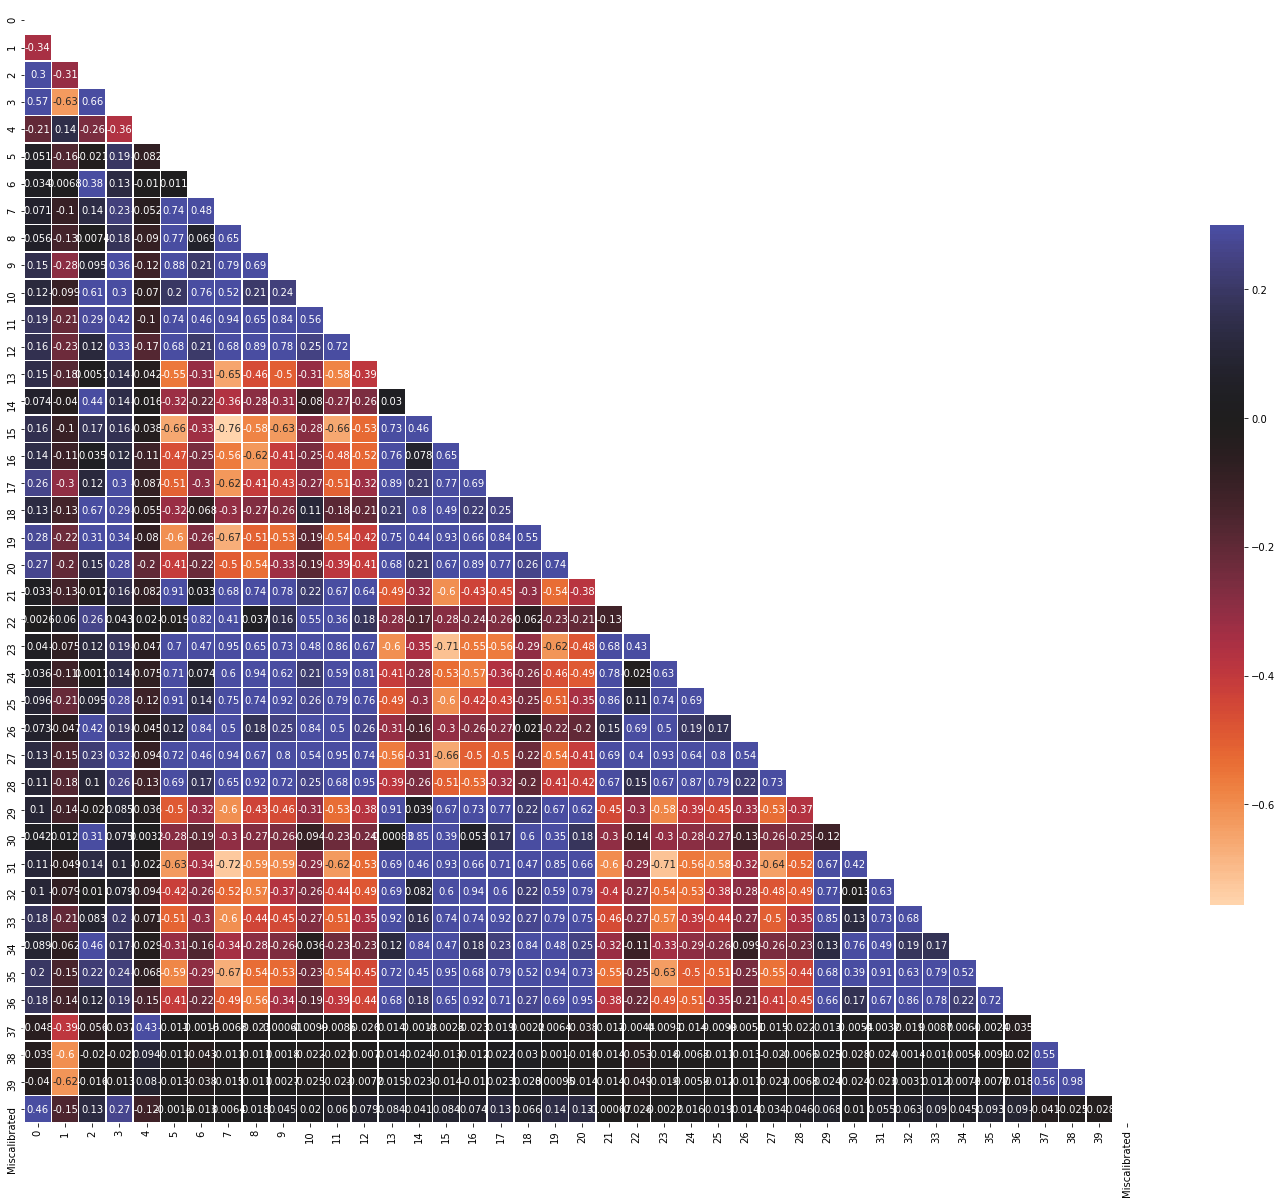

In [82]:
corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap='icefire_r',mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, ax=ax, cbar_kws={"shrink": 0.5})
corr_df=None

In [71]:
from sklearn.model_selection import train_test_split
X = data
y = training_data['Miscalibrated']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.svm import SVR
dtr = DecisionTreeRegressor()
knr = KNeighborsRegressor()
logr = LogisticRegression()
linr = LinearRegression()
sgd = SGDRegressor()
svr = SVR()
models = [dtr, knr,linr, sgd, svr]
for model in models:
    model.fit(X_train, y_train)
    print(model)
    print(model.score(X_test, y_test))
    print('/n')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
-0.08673397592193277
/n
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
0.2795058584831718
/n
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.35231491689567906
/n
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_